<a href="https://colab.research.google.com/github/joshdsolis/DS-Unit-1-Sprint-4-Statistical-Tests-and-Experiments/blob/master/DS_Unit_1_Sprint_Challenge_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Science Unit 1 Sprint Challenge 4

## Exploring Data, Testing Hypotheses

In this sprint challenge you will look at a dataset of people being approved or rejected for credit.

https://archive.ics.uci.edu/ml/datasets/Credit+Approval

Data Set Information: This file concerns credit card applications. All attribute names and values have been changed to meaningless symbols to protect confidentiality of the data. This dataset is interesting because there is a good mix of attributes -- continuous, nominal with small numbers of values, and nominal with larger numbers of values. There are also a few missing values.

Attribute Information:
- A1: b, a.
- A2: continuous.
- A3: continuous.
- A4: u, y, l, t.
- A5: g, p, gg.
- A6: c, d, cc, i, j, k, m, r, q, w, x, e, aa, ff.
- A7: v, h, bb, j, n, z, dd, ff, o.
- A8: continuous.
- A9: t, f.
- A10: t, f.
- A11: continuous.
- A12: t, f.
- A13: g, p, s.
- A14: continuous.
- A15: continuous.
- A16: +,- (class attribute)

Yes, most of that doesn't mean anything. A16 (the class attribute) is the most interesting, as it separates the 307 approved cases from the 383 rejected cases. The remaining variables have been obfuscated for privacy - a challenge you may have to deal with in your data science career.

Sprint challenges are evaluated based on satisfactory completion of each part. It is suggested you work through it in order, getting each aspect reasonably working, before trying to deeply explore, iterate, or refine any given step. Once you get to the end, if you want to go back and improve things, go for it!

## Part 1 - Load and validate the data

- Load the data as a `pandas` data frame.
- Validate that it has the appropriate number of observations (you can check the raw file, and also read the dataset description from UCI).
- UCI says there should be missing data - check, and if necessary change the data so pandas recognizes it as na
- Make sure that the loaded features are of the types described above (continuous values should be treated as float), and correct as necessary

This is review, but skills that you'll use at the start of any data exploration. Further, you may have to do some investigation to figure out which file to load from - that is part of the puzzle.

In [0]:
# TODO
import pandas as pd
import numpy as np
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/credit-screening/crx.data', header=None)

In [89]:
df.shape

(690, 16)

In [90]:
df[3].unique()

array(['u', 'y', '?', 'l'], dtype=object)

In [0]:
df = df.replace('?', np.nan)

In [92]:
df.isna().sum()

0     12
1     12
2      0
3      6
4      6
5      9
6      9
7      0
8      0
9      0
10     0
11     0
12     0
13    13
14     0
15     0
dtype: int64

In [93]:
df = df.dropna(how = 'any')
df.shape

(653, 16)

In [94]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,00202,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,00043,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,00280,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,00100,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,00120,0,+


In [95]:
df.dtypes

0      object
1      object
2     float64
3      object
4      object
5      object
6      object
7     float64
8      object
9      object
10      int64
11     object
12     object
13     object
14      int64
15     object
dtype: object

In [0]:
df[1] = df[1].astype(float)
df[2] = df[2].astype(float)
df[10] = df[2].astype(float)
df[13] = df[2].astype(float)
df[14] = df[2].astype(float)

In [97]:
df.dtypes

0      object
1     float64
2     float64
3      object
4      object
5      object
6      object
7     float64
8      object
9      object
10    float64
11     object
12     object
13    float64
14    float64
15     object
dtype: object

## Part 2 - Exploring data, Testing hypotheses

The only thing we really know about this data is that A16 is the class label. Besides that, we have 6 continuous (float) features and 9 categorical features.

Explore the data: you can use whatever approach (tables, utility functions, visualizations) to get an impression of the distributions and relationships of the variables. In general, your goal is to understand how the features are different when grouped by the two class labels (`+` and `-`).

For the 6 continuous features, how are they different when split between the two class labels? Choose two features to run t-tests (again split by class label) - specifically, select one feature that is *extremely* different between the classes, and another feature that is notably less different (though perhaps still "statistically significantly" different). You may have to explore more than two features to do this.

For the categorical features, explore by creating "cross tabs" between them and the class label, and apply the Chi-squared test to them. There are 9 categorical features - as with the t-test, try to find one where the Chi-squared test returns an extreme result (rejecting the null that the data are independent), and one where it is less extreme.

**NOTE** - "less extreme" just means smaller test statistic/larger p-value. Even the least extreme differences may be strongly statistically significant.

Your *main* goal is the hypothesis tests, so don't spend too much time on the exploration/visualization piece. That is just a means to an end. This is challenging, so manage your time and aim for a baseline of at least running two t-tests and two Chi-squared tests before polishing. And don't forget to answer the questions in part 3, even if your results in this part aren't what you want them to be.

In [0]:
# TODO
df_p = df[(df[15]=='+')]
df_n = df[(df[15]=='-')]

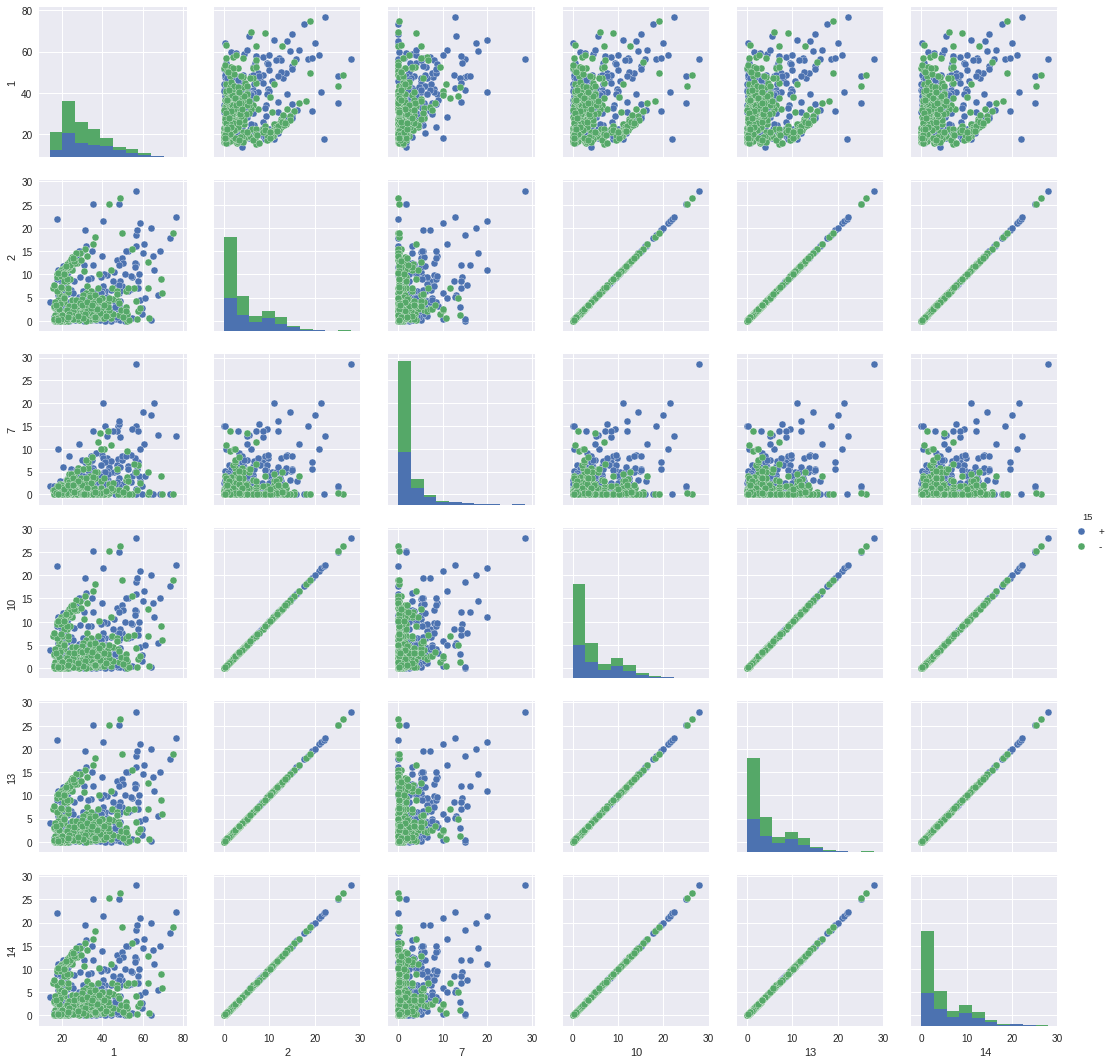

In [99]:
import seaborn as sns

sns.pairplot(data=df, hue = 15)

In [100]:
import scipy
scipy.stats.ttest_ind(df_p[7],df_n[7])

Ttest_indResult(statistic=9.002392498622463, pvalue=2.4079238505859142e-18)

In [101]:
scipy.stats.ttest_ind(df_p[1],df_n[1])

Ttest_indResult(statistic=4.675662433767456, pvalue=3.5636710933835225e-06)

In [102]:
scipy.stats.ttest_ind(df_p[14],df_n[14])

Ttest_indResult(statistic=5.400813416576192, pvalue=9.310154396147606e-08)

In [122]:
pd.crosstab(df[0], df[15])

15,+,-
0,,
a,95,108
b,201,249


In [121]:
pd.crosstab(df[4], df[15])

15,+,-
4,,
g,249,250
gg,2,0
p,45,107


In [120]:
pd.crosstab(df[8], df[15])

15,+,-
8,,
f,18,286
t,278,71


In [0]:
df_new = df_n[:296]

In [119]:
scipy.stats.chi2_contingency(pd.crosstab(df[8], df[15]))

(353.48271594103153,
 7.391616628556031e-79,
 1,
 array([[137.80091884, 166.19908116],
        [158.19908116, 190.80091884]]))

In [123]:
scipy.stats.chi2_contingency(pd.crosstab(df[0], df[15]))

(0.17764082160253514,
 0.6734085695133722,
 1,
 array([[ 92.01837672, 110.98162328],
        [203.98162328, 246.01837672]]))

##A9 has a p square value of 7.39e-79, rejects the null

##A1 has a p square value of 0.673, fails to reject the null

##A8 is extremely different between the classes
##A1 is notably less so, but still statistically significant

## Part 3 - Analysis and Interpretation

Now that you've looked at the data, answer the following questions:

- Interpret and explain the two t-tests you ran - what do they tell you about the relationships between the continuous features you selected and the class labels?
- Interpret and explain the two Chi-squared tests you ran - what do they tell you about the relationships between the categorical features you selected and the class labels?
- What was the most challenging part of this sprint challenge?

Answer with text, but feel free to intersperse example code/results or refer to it from earlier.

1) The two t-tests told me the statistic and p-value. A smaller p-value, ideally smaller than 0.05 suggests the two sets of data are related. The statistic indicates the difference in averages of the two sets of data.

A8 was extremely different because the p-value was extremely small, rejecting the null hypothesis that the classes are the same.
A1 was notably less different, but still significantly different so as to reject the null hypothesis that the classes are the same again.


2) The Chi-squared tests are designed to analyze categorical data. It tells me about the relationship between the class labels. Using crosstab, I'm able to grab a count of each categorical variable and split the count between class labels.

The p-value of the chi-square test on the crosstab tells us if the class labels are independent or not. The null hypothesis is that they are independent, and the lower p-value (below 0.05) allows us to reject the null hypothesis.

A9 had an extremely small p-value between the classes, and rejects the null.
A1 had a p value >0.05, failing to reject the null.

3) The hardest part of this sprint challenge was figuring out to use crosstab for the chi-square test, and even then I'm not sure I did it right. The second hardest part of the sprint challenge was interpreting the results and putting into words what I did in code.